# Klassische Modelle

Im folgenden Notebook werden einige klassische Modelle trainiert und evaluiert. Die Modelle sind:
- Linear Regression
- Gradient Boosting
- K Nearest Neighbors
- Random Forest
- Support Vector Machine
- XGBoost

Für das Training der Modelle wird auf die Erkenntnisse des vorherigen Notebooks zurückgegriffen. Das bedeutet, dass die Modelle mit dem TimeSeriesSplit aufgeteilt und mit MAPE evaluiert werden. Da die Vorgehensweise immer dieselbe ist und SKLearn auch bei verschiedenen Modellen dasselbe Interface anbietet, wurde das Trainieren in eine eigene Klasse ausgelagert. Diese Klasse `FurnaceModelTrainer` ist in `helper.py` zu finden, da sie auch noch im folgenden Notebook verwendet wird.

Die Trainingsklasse stellt verschiedene Methoden zur Verfügung:
- `cross_validation()`: Führt das Training mit Cross Validation durch
- `train()`: Trainiert das Modell mit allen Daten
- `visualize_split()`: Erstellt zwei Visualisierungen, um die Qualität des Modells visuell zu beurteilen.

Zunächst werden alle Daten geladen:

In [1]:
from helper import *

df = load_merged_data(only_standard_refuelling=True)

Nun wird festgelegt, mit welchen Spalten trainiert werden soll. Dabei werden nur Spalten verwendet, die später auch bei der Anwendung zur Verfügung stehen werden.

In [2]:
input_columns = [
    'refuellingTimePoint', 'refuellingTimePoint_5', 'refuellingTimePoint_10', 'refuellingTimePoint_15', 'refuellingTimePoint_30', 'refuellingTimePoint_60',
    'bufferChargingDegree', 'bufferChargingDegree_5', 'bufferChargingDegree_10', 'bufferChargingDegree_15', 'bufferChargingDegree_30', 'bufferChargingDegree_60',
    'Anheizen', 'Anzünden', 'Ausbrennen', 'Ausgeschaltet', 'Automatik', 'Vorbelüften', 'Zündung bereit',
    'Year sin', 'Year cos',
    'refuellingQuantity',
    'residualOxygen', 'flueGasTemperature',
    'bufferTemperatureTop', 'bufferTemperatureMiddleTop', 'bufferTemperatureMiddle', 'bufferTemperatureMiddleBottom', 'bufferTemperatureBottom',
    'bufferUsableEnergyMax', 'bufferUsableEnergyActual',
    'outsideTemperature',
    'weatherTemperature', 'weatherWindX', 'weatherWindY',
    'weatherTemperature_6', 'weatherWindX_6', 'weatherWindY_6',
    'weatherTemperature_12', 'weatherWindX_12', 'weatherWindY_12',
    'weatherTemperature_18', 'weatherWindX_18', 'weatherWindY_18',
    'weatherTemperature_24', 'weatherWindX_24', 'weatherWindY_24'
]

## Linear Regression

Als erstes Modell wird eine lineare Regression getestet, da die lineare Regression ein einfaches Verfahren ist. Dabei wird die `LinearRegression` Klasse von SKLearn verwendet.

Die Trainingsklasse `FurnaceModelTrainer` wird mit einigen Parametern initialisiert. Da bei den weiteren Modellen dieselben Parameter verwendet werden, werden diese hier kurz erläutert:
- `df`: Das DataFrame, das zum Trainieren verwendet werden soll
- `input_columns`: Die Spalten, die als Input verwendet werden sollen
- `slice_step`: Die Schrittweite, mit der die Daten gesliced werden sollen. Da die Daten sehr viele Zeilen haben, wird nur jede `slice_step`-te Zeile verwendet. Das ist notwendig, um das Training zu beschleunigen. Die Schrittweite kann je nach gewünschter Genauigkeit angepasst werden.
- `cross_validation_splitter`: Der Splitter, der für das Training verwendet werden soll. Hier wird der `TimeSeriesSplit` verwendet, da dies im vorherigen Notebook als geeignete Methode ermittelt wurde.
- `model_builder`: Eine Funktion, die ein Modell zurückgibt. Da die Modelle alle dieselbe Schnittstelle haben, kann hier eine Funktion übergeben werden, die das Modell initialisiert und zurückgibt.

Einige Paramter werden hier nicht verwendet, da sie für Gradient Boosting nicht notwendig sind. Diese werden bei den anderen Modellen verwendet. Dies sind die Parameter:
- `generate_eval_set`: Gibt an, ob ein Evaluationsset generiert werden soll. Dies wird für XGBoost benötigt.
- `fit_params`: Parameter, die an die `fit()` Methode des Modells übergeben werden sollen.


Während und nach dem Training werden einige Informationen ausgegeben. Nach jedem trainierten Split wird die Evaluation des Modells in diesem Schritt ausgegeben. Dabei wird der MAPE, der MSE und der RMSE augegeben. Da `SkipFirstTimeSeriesSplit` 5 Splits generiert und die ersten zwei übersprungen werden, werden hier 3 Splits ausgegeben. Nach dem Training wird der MAPE des gesamten Modells ausgegeben, indem der Durchschnitt der einzelnen Splits berechnet wird.

In [3]:
from sklearn.linear_model import LinearRegression

linearTrainer = FurnaceModelTrainer(
    df, input_columns, slice_step=50,
    cross_validation_splitter=SkipFirstTimeSeriesSplit(n_splits=5, n_skip_splits=2),
    model_builder=lambda: LinearRegression())

linearTrainer.cross_validation()

Finished fold
    Train Duration: 0.803840160369873 seconds
    Train Size: 88741
    MAPE: 1.4672793561370692
    MSE: 33.23871322632694
    RSME: 5.765302526869421
Finished fold
    Train Duration: 1.279041051864624 seconds
    Train Size: 118322
    MAPE: 0.6452559696311826
    MSE: 157.23433321804097
    RSME: 12.539311512919717
Finished fold
    Train Duration: 1.6408538818359375 seconds
    Train Size: 147902
    MAPE: 1.3203627890390592
    MSE: 69.19613941560414
    RSME: 8.318421690176818
Average MAPE: 1.144299371602437
Average MSE: 86.55639528665735
Average RSME: 9.303568954259292


1.144299371602437

Um die Qualität des Modells zu beurteilen, wird die `visualize_split()` Methode verwendet. Diese erstellt zwei Visualisierungen:

Zunächst wird wieder der aus dem vorherigen Notebook bekannte Scatterplot verwendet: Es werden in einem Scatter Plot die tatsächlichen und die vorhergesagten Werte gegeneinander aufgetragen. Es gelten aber weiterhin die Einschränkungen, die im vorherigen Notebook beschrieben wurden.

Sowohl der MAPE als auch die erste Visualisierung versuchen ein gesamtheitlichen Blick auf das Modell zu werfen. Für eine umfassende Bewertung des Modells ist dies auch der richtige Ansatz. Die zweite Visualisierung verfolgt jedoch das Ziel, das Modell anschaulich zu machen. Dafür wird die Vorhersage des Modells (rot), die Vorhersage des Ofens (blau) und die tatsächliche Zielgröße im Zeitverlauf (Linie) für einige Tage dargestellt.     
    
bei allen weiteren Modellen werden dieselben Visualisierungen verwendet.

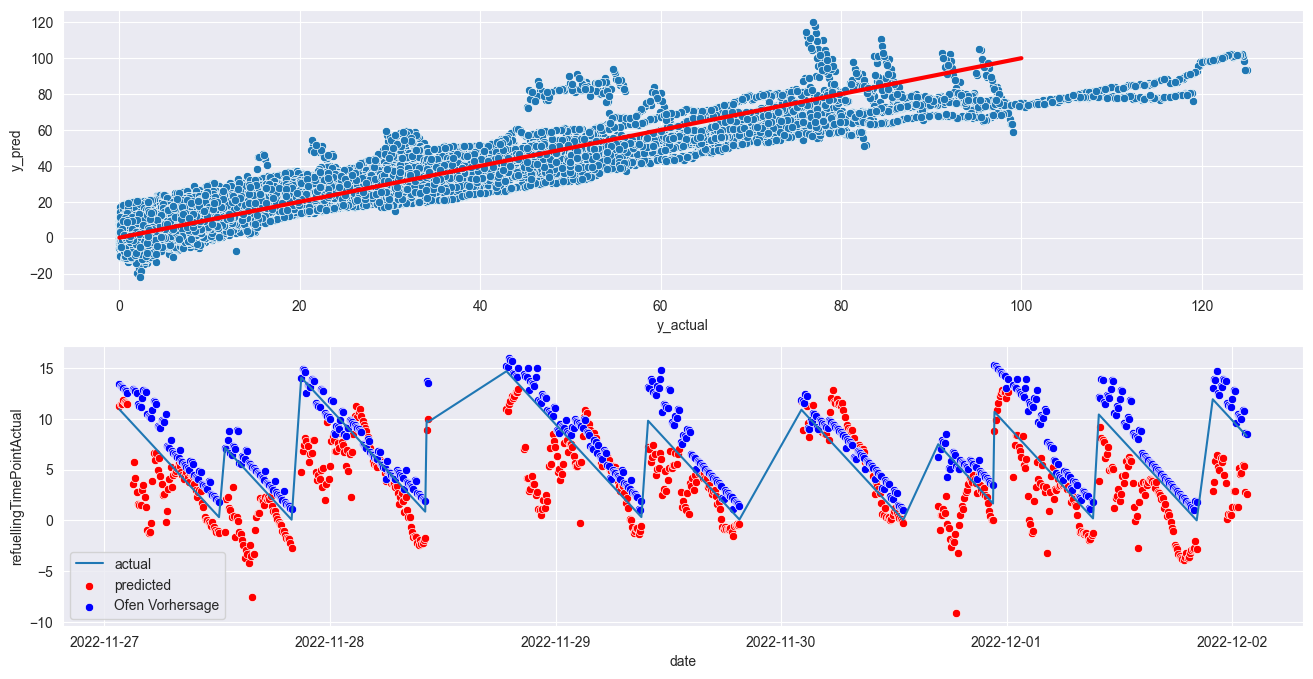

In [4]:
linearTrainer.visualize_split()

## Gradient Boosting

Als zweites Modell wird Gradient Boosting verwendet. Dabei wird die `GradientBoostingRegressor` Klasse von SKLearn verwendet.

Die Klasse `FurnaceModelTrainer` hat dabei dieselben Parameter wie bei der linearen Regression. Es wird jedoch ein anderer Modellbuilder verwendet.
Die Ausgabe und die Visualisierungen sind ebenfalls dieselben wie bei der linearen Regression.

In [5]:
from sklearn.ensemble import GradientBoostingRegressor

gradientBoostingTrainer = FurnaceModelTrainer(
    df, input_columns, slice_step=100,
    cross_validation_splitter=SkipFirstTimeSeriesSplit(n_splits=5, n_skip_splits=2),
    model_builder=lambda: GradientBoostingRegressor())

gradientBoostingTrainer.cross_validation()

Finished fold
    Train Duration: 25.829803943634033 seconds
    Train Size: 44371
    MAPE: 0.4673494449603794
    MSE: 18.54560653756861
    RSME: 4.3064610224137185
Finished fold
    Train Duration: 33.989563941955566 seconds
    Train Size: 59161
    MAPE: 0.38109402601249454
    MSE: 137.33207461811085
    RSME: 11.718876849686188
Finished fold
    Train Duration: 41.32443189620972 seconds
    Train Size: 73951
    MAPE: 0.6021386501274861
    MSE: 65.6743867738367
    RSME: 8.103973517592262
Average MAPE: 0.48352737370012
Average MSE: 73.85068930983873
Average RSME: 8.593642377353081


0.48352737370012

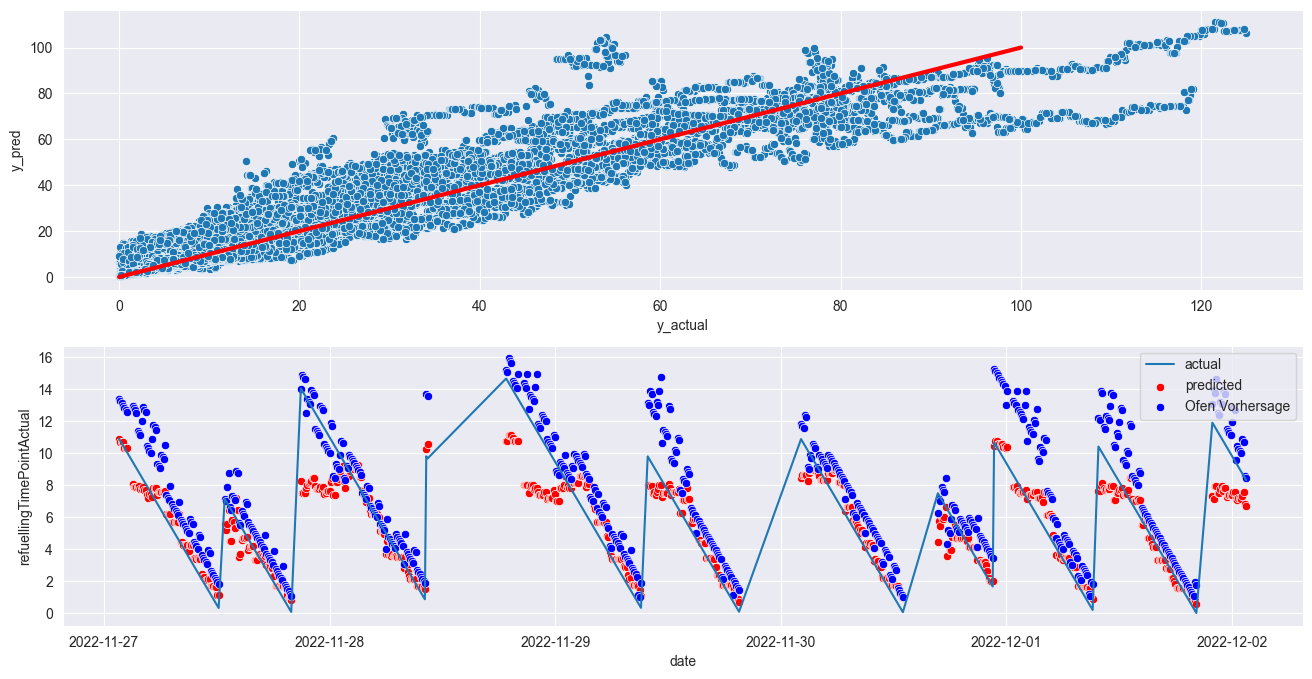

In [6]:
gradientBoostingTrainer.visualize_split()

## K Nearest Neighbors

Als drittes Modell wird K Nearest Neighbors verwendet. Dabei wird die `KNeighborsRegressor` Klasse von SKLearn verwendet.

Bei dem Ergebnis ist auffallend, dass der MAPE ähnlich zu dem des `GradientBoostingRegressor` ist, der MES/RMSE jedoch deutlich schlechter.
Anhand des MAPE wäre das Modell außerdem bereits besser als die Vorhersage des Ofens. Mit dem MSE/RMSE ist das Modell jedoch schlechter bewertet als die Vorhersage des Ofens.
Daran wird deutlich, dass die Auswahl des Evaluationsmaßes sehr wichtig ist und an die Anwendung angepasst werden muss.

In [7]:
from sklearn.neighbors import KNeighborsRegressor

knnTrainer = FurnaceModelTrainer(df, input_columns, slice_step=50, cross_validation_splitter=SkipFirstTimeSeriesSplit(n_splits=5, n_skip_splits=2), model_builder=lambda: KNeighborsRegressor(n_neighbors=5))
knnTrainer.cross_validation()

Finished fold
    Train Duration: 4.022472858428955 seconds
    Train Size: 88741
    MAPE: 0.4557940877867511
    MSE: 41.639519125501806
    RSME: 6.452869061549428
Finished fold
    Train Duration: 5.087186813354492 seconds
    Train Size: 118322
    MAPE: 0.5337381721796091
    MSE: 390.88285812573844
    RSME: 19.77075765178812
Finished fold
    Train Duration: 6.093019008636475 seconds
    Train Size: 147902
    MAPE: 0.3880230777813443
    MSE: 109.87178960315178
    RSME: 10.481974508800896
Average MAPE: 0.45918511258256817
Average MSE: 180.79805561813066
Average RSME: 13.446116748642735


0.45918511258256817

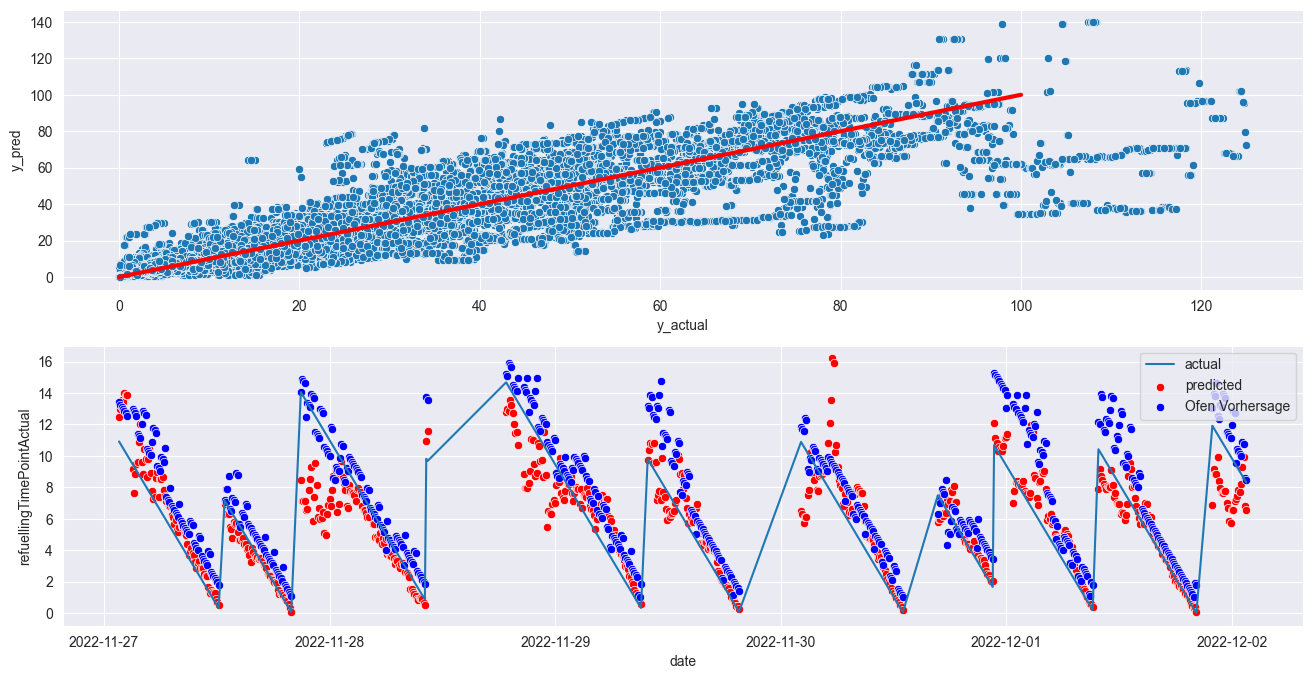

In [8]:
knnTrainer.visualize_split()

## Random Forest

Als viertes Modell wird Random Forest verwendet. Dabei wird die `RandomForestRegressor` Klasse von SKLearn verwendet.

In [9]:
from sklearn.ensemble import RandomForestRegressor

randomForestTrainer = FurnaceModelTrainer(df, input_columns, slice_step=500, cross_validation_splitter=SkipFirstTimeSeriesSplit(n_splits=5, n_skip_splits=2), model_builder=lambda: RandomForestRegressor())
randomForestTrainer.cross_validation()

Finished fold
    Train Duration: 17.638860940933228 seconds
    Train Size: 8875
    MAPE: 0.24033222391992318
    MSE: 18.070353508889955
    RSME: 4.250923841812501
Finished fold
    Train Duration: 23.32520604133606 seconds
    Train Size: 11833
    MAPE: 0.25550426425512845
    MSE: 165.35255564178644
    RSME: 12.858948465632267
Finished fold
    Train Duration: 31.430104970932007 seconds
    Train Size: 14791
    MAPE: 0.25834884395134583
    MSE: 58.69132638117012
    RSME: 7.661026457412226
Average MAPE: 0.25139511070879916
Average MSE: 80.70474517728216
Average RSME: 8.983581979215316


0.25139511070879916

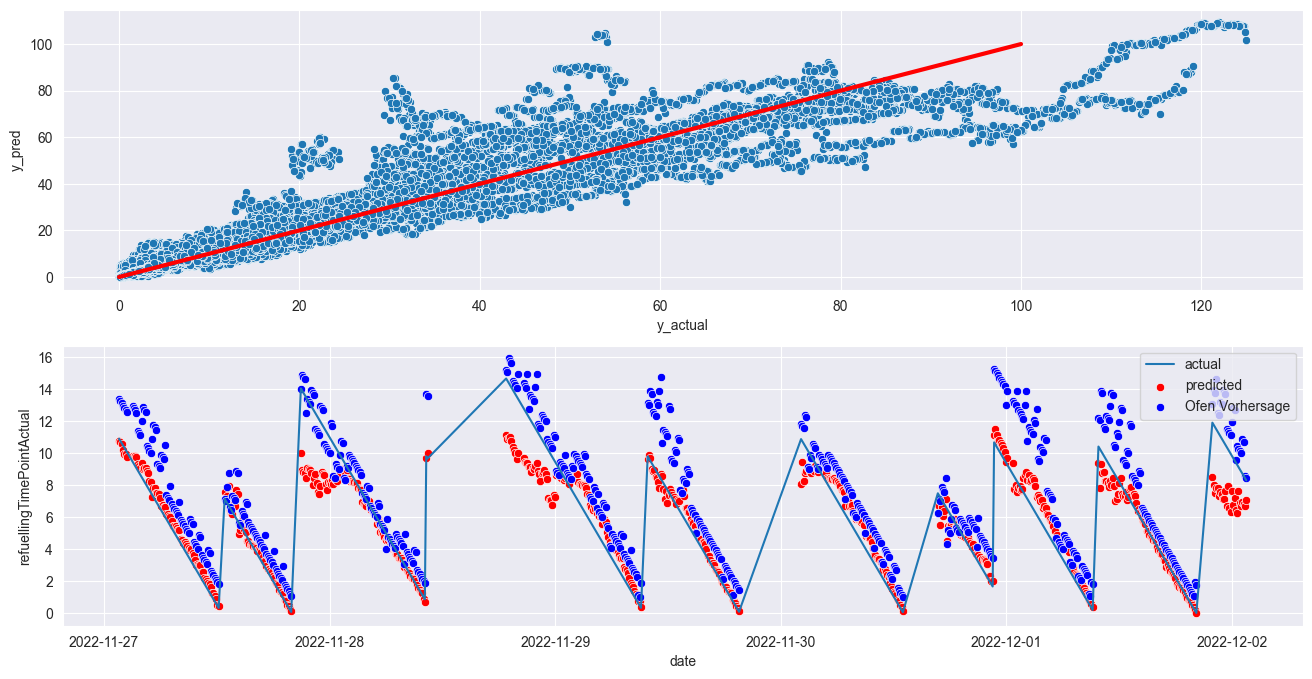

In [10]:
randomForestTrainer.visualize_split()

## Support Vector Machine

Als fünftes Modell wird Support Vector Machine verwendet. Dabei wird die `SVR` Klasse von SKLearn verwendet.

In [11]:
from sklearn.svm import SVR

svrTrainer = FurnaceModelTrainer(df, input_columns, slice_step=500, cross_validation_splitter=SkipFirstTimeSeriesSplit(n_splits=5, n_skip_splits=2), model_builder=lambda: SVR())
svrTrainer.cross_validation()

Finished fold
    Train Duration: 23.053835153579712 seconds
    Train Size: 8875
    MAPE: 0.5807024882744024
    MSE: 28.464272832122195
    RSME: 5.3351919208330445
Finished fold
    Train Duration: 31.518623113632202 seconds
    Train Size: 11833
    MAPE: 0.4332046258933037
    MSE: 171.3173147500223
    RSME: 13.088824039997721
Finished fold
    Train Duration: 42.46333384513855 seconds
    Train Size: 14791
    MAPE: 0.46367335747945104
    MSE: 50.141785100375735
    RSME: 7.081086435030696
Average MAPE: 0.49252682388238567
Average MSE: 83.30779089417341
Average RSME: 9.127310167523255


0.49252682388238567

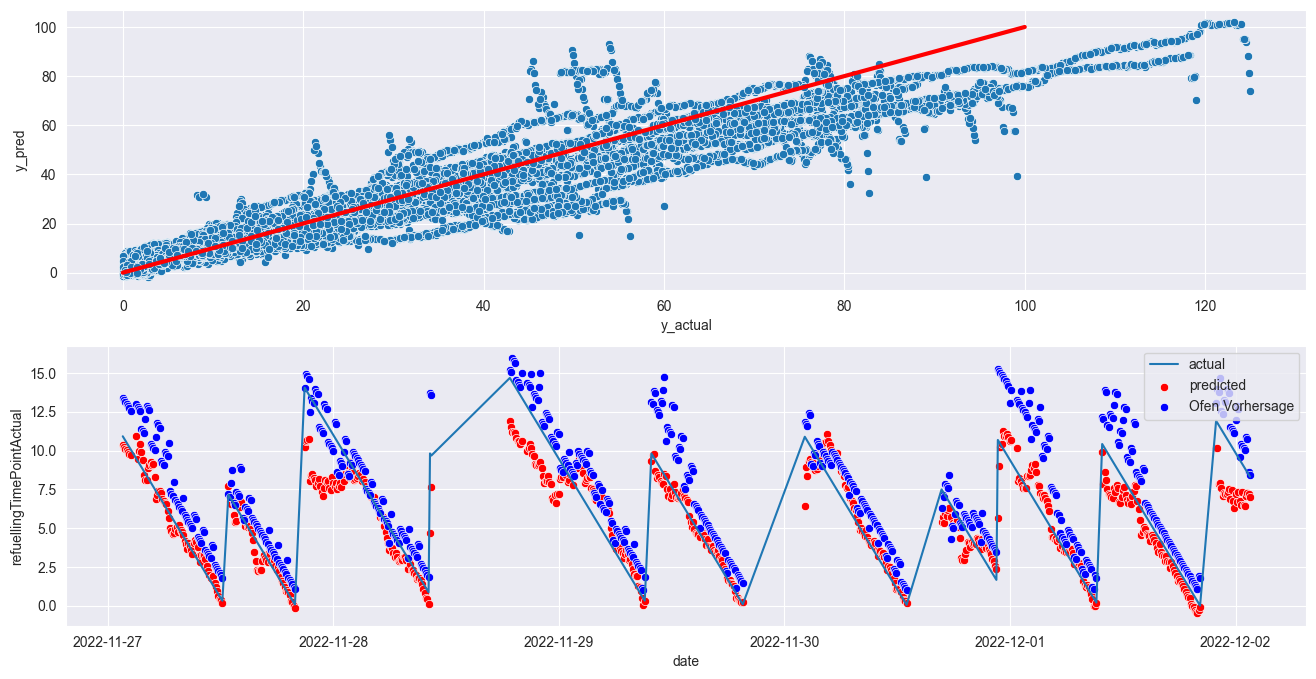

In [12]:
svrTrainer.visualize_split()

## XGBoost

Als letztes Modell wird XGBoost verwendet. Dabei wird die `XGBRegressor` Klasse von XGBoost verwendet.

In [13]:
import xgboost as xgb

model_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mape',
    'early_stopping_rounds': 50
}

xgboostTrainer = FurnaceModelTrainer(
    df, input_columns, slice_step=100,
    cross_validation_splitter=SkipFirstTimeSeriesSplit(n_splits=5, n_skip_splits=2),
    model_builder=lambda: xgb.XGBRegressor(**model_params), generate_eval_set=True, fit_params={'verbose': False})
xgboostTrainer.cross_validation()

Finished fold
    Train Duration: 3.540761947631836 seconds
    Train Size: 35496
    MAPE: 0.40151676971131794
    MSE: 37.78923358555041
    RSME: 6.147294818499469
Finished fold
    Train Duration: 6.067199945449829 seconds
    Train Size: 47328
    MAPE: 0.36241027907588474
    MSE: 202.66773501723281
    RSME: 14.236141858566626
Finished fold
    Train Duration: 5.25589394569397 seconds
    Train Size: 59160
    MAPE: 0.36867736132014106
    MSE: 93.38341988505965
    RSME: 9.66350970843718
Average MAPE: 0.3775348033691146
Average MSE: 111.28012949594763
Average RSME: 10.548939733259814


0.3775348033691146

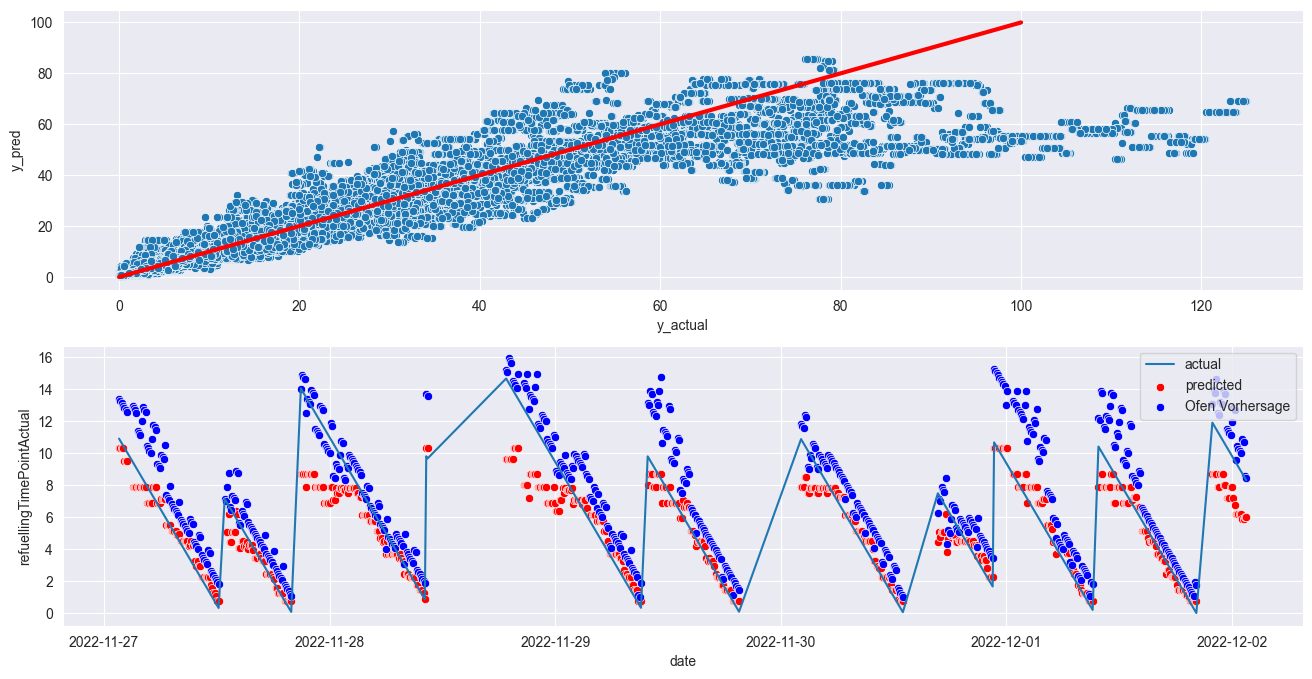

In [14]:
xgboostTrainer.visualize_split()

### Custom Objective

XGBoost ermöglicht es, eine eigene Zielfunktion zu definieren, nach der optimiert werden soll. Bisher wurde der MSE (`reg:squarederror`) als Optimierungsfunktion eingesetzt. Dafür müssen lediglich die ersten zwei Ableitungen bestimmt werden.
Da der MAPE als Evaluationsmaß verwendet wird, ist es sinnvoll, auch den MAPE als Optimierungsfunktion zu verwenden. Dies ist jedoch nicht direkt möglich, da der MAPE nicht überall 2x differenzierbar ist. Außerdem ist die zweite Ableitung, wo sie existiert, 0.

Dies lässt sich einfach nachrechnen. Für $y_i > \hat{y_i}$ und $y_i > 0$ gilt:

$$MAPE = \frac{1}{n} \sum_{i}^{n-1} \frac{\left|y_i - \hat{y_i}\right|}{\left|y_i\right|} = \frac{1}{n} \sum_{i=1}^{n} \frac{y_i - \hat{y_i}}{y_i}$$

$$\frac{\partial MAPE}{\partial \hat{y_i}} = \frac{1}{n} \sum_{i=1}^{n} \frac{1}{y_i} = \frac{1}{y_i}$$

$$\frac{\partial^2 MAPE}{\partial \hat{y_i}^2} = 0$$

Um dennoch die Prognoseabweichung zu gewichten (daher gleiche absolute Abweichung ist schlimmer bei kleineren Werten), kann der MSE mit dem Faktor $\frac{1}{y_i}$ gewichtet werden. Dies führt zu folgender Zielfunktion:

$$\frac{1}{n} \sum_{i=1}^{n} \frac{1}{y_i} \left(y_i - \hat{y_i}\right)^2$$

Diese Funktion ist nun überall 2x differenzierbar und kann als Zielfunktion verwendet werden:


$$\frac{\partial}{\partial \hat{y_i}} \frac{1}{n} \sum_{i=1}^{n} \frac{1}{y_i} \left(y_i - \hat{y_i}\right)^2 = \frac{1}{n} \sum_{i=1}^{n} \frac{1}{y_i} \left(2 \hat{y_i} - 2 y_i\right) = \frac{1}{n} \sum_{i=1}^{n} 2 \frac{\hat{y_i}}{y_i} - 2$$

$$\frac{\partial^2}{\partial \hat{y_i}^2} \frac{1}{n} \sum_{i=1}^{n} \frac{1}{y_i} \left(y_i - \hat{y_i}\right)^2 = \frac{1}{n} \sum_{i=1}^{n} \frac{2}{y_i}$$

Im Folgenden wird diese Zielfunktion definiert und XGBoost mit dieser Zielfunktion trainiert. Dabei wird weiterhin der MAPE als Evaluationsmaß verwendet. Die Ausgabe und die Visualisierungen sind dieselben wie bei den anderen Modellen.
Im Vergleich zu dem zuvor trainierten XGBoost Modell mit ansonsten den gleichen Parametern, hat sich der MAPE deutlich verbessert.

[XGBoost Dokumentation zu custom objective](https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html)

In [15]:
def custom_obj(y_true, y_pred):
    grad = 2 * y_pred / y_true - 2
    hess = 2 / y_true
    return grad, hess

model_params_custom_obj = {
    'objective': custom_obj,
    'eval_metric': 'mape',
    'early_stopping_rounds': 50
}

xgboostTrainerCustomObj = FurnaceModelTrainer(
    df, input_columns, slice_step=100,
    cross_validation_splitter=SkipFirstTimeSeriesSplit(n_splits=5, n_skip_splits=2),
    model_builder=lambda: xgb.XGBRegressor(**model_params_custom_obj), generate_eval_set=True, fit_params={'verbose': False})
xgboostTrainerCustomObj.cross_validation()

Finished fold
    Train Duration: 3.253462076187134 seconds
    Train Size: 35496
    MAPE: 0.2492990240976867
    MSE: 34.08603295403125
    RSME: 5.83832449886363
Finished fold
    Train Duration: 5.073553085327148 seconds
    Train Size: 47328
    MAPE: 0.24377108950514
    MSE: 181.26463233034863
    RSME: 13.463455437975373
Finished fold
    Train Duration: 5.274367809295654 seconds
    Train Size: 59160
    MAPE: 0.22875290647316096
    MSE: 85.71684453958811
    RSME: 9.258339189054812
Average MAPE: 0.24060767335866254
Average MSE: 100.35583660798933
Average RSME: 10.017776031035497


0.24060767335866254

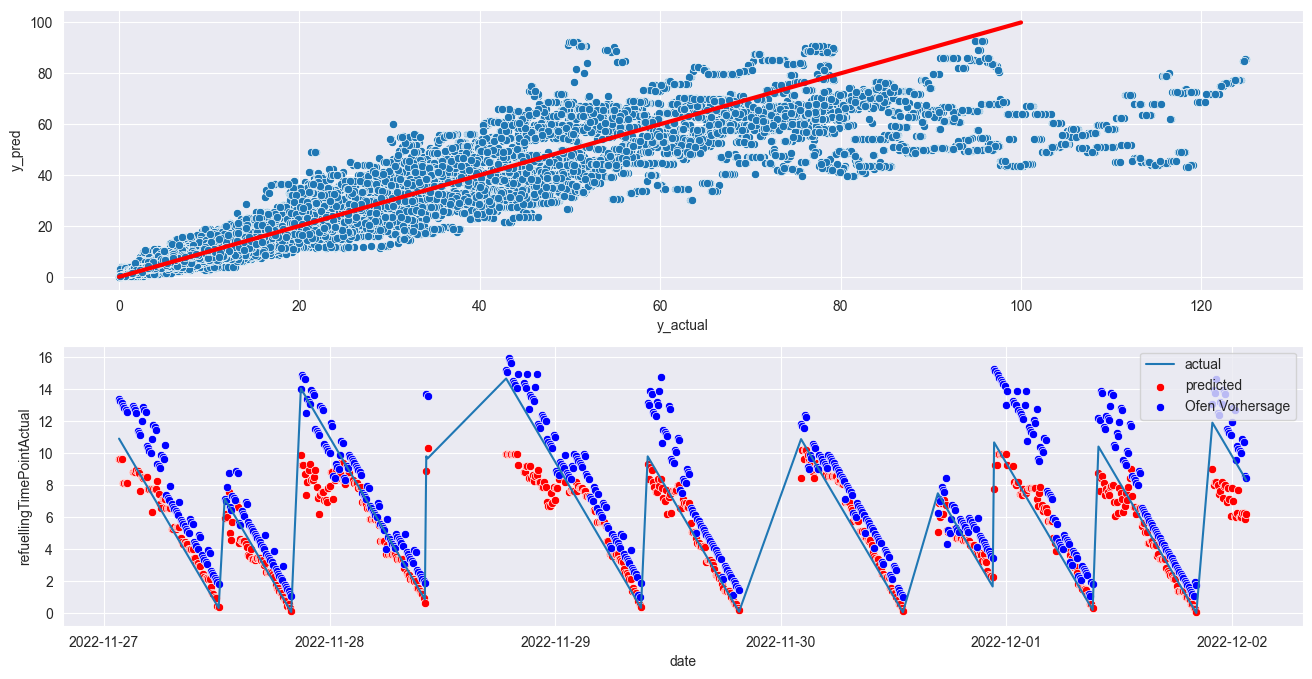

In [16]:
xgboostTrainerCustomObj.visualize_split()

## Vergleich der Modelle

Nach dem nun alle Modelle trainiert wurden, werden diese verglichen. Dazu wird eine Tabelle erstellt, in der die Modelle nach dem MAPE sortiert sind. XGBRegressor ist zweimal in der Tabelle, da einmal die Standard-Zielfunktion und einmal die custom Zielfunktion verwendet wurde.

In der Tabelle wird auch noch einmal deutlich, dass die Wahl der Evaluationsmetrik sehr wichtig ist. Würde man den MSE verwenden, um die Modelle zu vergleichen, wäre die Reihenfolge der Modelle anders.

Bisher wurden alle Modelle mit den Standardparametern trainiert. Es ist jedoch möglich, die Parameter der Modelle zu optimieren. Dafür kann Hyperparameter Tuning verwendet werden. Dies wird in den nächsten Nodebooks durchgeführt.
Hyperparameter Tuning ist jedoch sehr rechenintensiv. Deshalb werden nur die beiden Modelle mit dem besten MAPE optimiert. Dies ist das XGBoost Modell und RandomForestRegressor.  

In [17]:
allModelTrainer = [
    linearTrainer,
    gradientBoostingTrainer,
    knnTrainer,
    randomForestTrainer,
    svrTrainer,
    xgboostTrainer,
    xgboostTrainerCustomObj
]

comparisson_df = pd.DataFrame({
    'Model': [trainer.model_builder().__class__.__name__ for trainer in allModelTrainer],
    'MAPE': [trainer.mape for trainer in allModelTrainer],
    'MSE': [trainer.mse for trainer in allModelTrainer]
})

comparisson_df = comparisson_df.sort_values(by='MAPE', ascending=True)
comparisson_df


,Model,MAPE,MSE
6,XGBRegressor,0.240608,100.355837
3,RandomForestRegressor,0.251395,80.704745
5,XGBRegressor,0.377535,111.280129
2,KNeighborsRegressor,0.459185,180.798056
1,GradientBoostingRegressor,0.483527,73.850689
4,SVR,0.492527,83.307791
0,LinearRegression,1.144299,86.556395
